In [101]:
import tensorflow as tf
import numpy as np
import os

## 加载MNIST数据集

分别加载MNIST训练集、测试集、验证集

In [80]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [81]:
print("Image Shape: {}".format(X_train.shape))
print("label Shape: {}".format(y_train.shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Image Shape: (55000, 784)
label Shape: (55000, 10)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


## 数据处理

由于LeNet的输入为32x32xC，而MNIST每张图像的尺寸为28x28，所以需要对图像四周进行填充，并添加一维，使得每幅图像的形状为32x32x1。

In [82]:
# Pad images with 0s
X_train = np.array([np.pad(X_train[i].reshape((28, 28)), (2, 2), 'constant')[:, :, np.newaxis] for i in range(len(X_train))])
X_validation = np.array([np.pad(X_validation[i].reshape((28, 28)), (2, 2), 'constant')[:, :, np.newaxis] for i in range(len(X_validation))])
X_test = np.array([np.pad(X_test[i].reshape((28, 28)), (2, 2), 'constant')[:, :, np.newaxis] for i in range(len(X_test))])
    
print("Updated Image Shape: {}".format(X_train.shape))

Updated Image Shape: (55000, 32, 32, 1)


## MNIST数据展示

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


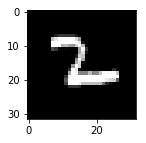

In [84]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze().reshape((32, 32))

plt.figure(figsize=(2,2))
plt.imshow(image, cmap="gray")
print(y_train[index])

## 打乱数据

In [85]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## LeNet网络结构

![LeNet](https://raw.githubusercontent.com/udacity/CarND-LeNet-Lab/b12183069bcd00bf33bc5c7fd60cd9c4ae2b1bdd/lenet.png)

### Input
  The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.
  LeNet的输入为32x32xC的图像，C为图像的通道数。在MNIST中，图像为灰度图，因此C等于1。

### Architecture
**Layer 1: Convolutional.** 输出为28x28x6的张量。

**Activation.** 激活函数。

**Pooling.** 输出为14x14x6的张量。

**Layer 2: Convolutional.** 输出为10x10x16的张量。

**Activation.** 激活函数。

**Pooling.** 输出为5x5x16的张量。

**Flatten.** 将张量展平为一维向量，使用`tf.contrib.layers.flatten`可以实现。

**Layer 3: Fully Connected.** 输出为120长度的向量。

**Activation.** 激活函数。

**Layer 4: Fully Connected.** 输出为84长度的向量。

**Activation.** 激活函数。

**Layer 5: Fully Connected (Logits).** 输出为10长度的向量。

In [86]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## TensorFlow设置

In [97]:
EPOCHS = 10
BATCH_SIZE = 128
log_dir = './log/'

In [98]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None, 10))

定义损失函数

In [99]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(cross_entropy)
train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

## 训练模型

In [103]:
saver = tf.train.Saver()
train_summary_writer = tf.summary.FileWriter(os.path.join(log_dir, 'train'))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_samples = len(X_train)
    
    step = 0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n_samples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(train, feed_dict={x: batch_x, y: batch_y})
            
            now_loss = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
            my_summary = tf.Summary(value=[
                tf.Summary.Value(tag="loss", simple_value=now_loss)
            ])
            train_summary_writer.add_summary(my_summary, step)
            train_summary_writer.flush()
            step += 1
            
        print(now_loss)
        
    saver.save(sess, './lenet/')
    print("Model saved")

0.041000955
0.028263032
0.023585664
0.033677526
0.012936876
0.040886696
0.039099906
0.008875431
0.040616836
0.0037371146
Model saved


## 评估模型

In [94]:
correct = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [95]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = sess.run(accuracy, feed_dict={x: X_test, y: y_test})
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.987
